In [1]:
import sklearn
print(sklearn.__version__)

1.3.2


In [76]:
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, classification_report
pd.set_option('display.max_columns',None)
import joblib

#### 

#### Importando a base de dados feita com o script de coleta de dados a partir do Yahoofinance, atualmente para não pesar temos apenas 3 ativos. Mas podemos fazer todos ativos da bolsa disponível quando desejar.

In [77]:
price_data = pd.read_parquet(f'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Dados_bolsa_interpolar.parquet')
price_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.289650,985,ABEV3.SA
1,2000-01-06,0.494478,0.494478,0.494478,0.494478,0.274967,227,ABEV3.SA
2,2000-01-12,0.481293,0.481293,0.481293,0.481293,0.267635,1137,ABEV3.SA
3,2000-01-13,0.484589,0.484589,0.484589,0.484589,0.269468,606,ABEV3.SA
4,2000-01-14,0.494478,0.494478,0.494478,0.494478,0.274967,6445,ABEV3.SA


In [78]:
price_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27031 entries, 0 to 27030
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       27031 non-null  datetime64[ns]
 1   Open       27031 non-null  float64       
 2   High       27031 non-null  float64       
 3   Low        27031 non-null  float64       
 4   Close      27031 non-null  float64       
 5   Adj Close  27031 non-null  float64       
 6   Volume     27031 non-null  int64         
 7   Ticker     27031 non-null  object        
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 1.6+ MB


#### Ordenando por data e ticker e pegando a diferença do dia anterior.

In [79]:
price_data['Date'] = pd.to_datetime(price_data['Date'])
price_data.sort_values(by = ['Ticker','Date'], inplace = True)

price_data['change_in_price'] = price_data['Close'].diff()
price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price
11773,2025-01-16,52.290001,53.270000,52.000000,52.669998,52.669998,220262800,VALE3.SA,0.070000
11774,2025-01-17,53.150002,54.490002,52.980000,54.490002,54.490002,54658700,VALE3.SA,1.820004
11775,2025-01-20,54.220001,54.490002,53.759998,54.290001,54.290001,12317600,VALE3.SA,-0.200001
11776,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000
11777,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001


In [80]:
# Função para suavização exponencial
def exponential_smoothing(data, alpha):
    """
    Aplica a suavização exponencial nos dados.
    :param data: Série de dados (array-like ou pandas Series).
    :param alpha: Fator de suavização (0 < alpha < 1).
    :return: Série suavizada.
    """
    smoothed = np.zeros(len(data))
    smoothed[0] = data[0]  # Inicializa com o primeiro valor
    for t in range(1, len(data)):
        smoothed[t] = alpha * data[t] + (1 - alpha) * smoothed[t-1]
    return smoothed

# Função para calcular o target
def calculate_target(data, d):
    """
    Calcula o target usando a fórmula do sinal da diferença de preços.
    :param data: Série de preços de fechamento (array-like ou pandas Series).
    :param d: Período para calcular a diferença futura.
    :return: Série com os valores do target (-1, 0, 1).
    """
    return np.sign(data.shift(-d) - data)



# Aplicando a suavização exponencial
alpha = 0.30
price_data['Smoothed_Close'] = price_data.groupby('Ticker')['Close'].transform(
    lambda x: exponential_smoothing(x.values, alpha)
)

# Calculando o target para d = 10 dias
d = 10
price_data['Prediction'] = price_data.groupby('Ticker')['Smoothed_Close'].transform(
    lambda x: calculate_target(x, d)
)

price_data.head()


,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.289650,985,ABEV3.SA,NaN,0.520882,-1.0
1,2000-01-06,0.494478,0.494478,0.494478,0.494478,0.274967,227,ABEV3.SA,-0.026404,0.512961,-1.0
2,2000-01-12,0.481293,0.481293,0.481293,0.481293,0.267635,1137,ABEV3.SA,-0.013185,0.503460,-1.0
3,2000-01-13,0.484589,0.484589,0.484589,0.484589,0.269468,606,ABEV3.SA,0.003296,0.497799,1.0
4,2000-01-14,0.494478,0.494478,0.494478,0.494478,0.274967,6445,ABEV3.SA,0.009889,0.496803,1.0


In [81]:
# Função para suavização exponencial
def exponential_smoothing(data, alpha):
    """
    Aplica a suavização exponencial nos dados.
    :param data: Série de dados (array-like ou pandas Series).
    :param alpha: Fator de suavização (0 < alpha < 1).
    :return: Série suavizada.
    """
    smoothed = np.zeros(len(data))
    smoothed[0] = data[0]  # Inicializa com o primeiro valor
    for t in range(1, len(data)):
        smoothed[t] = alpha * data[t] + (1 - alpha) * smoothed[t-1]
    return smoothed

# Função para calcular o target
def calculate_target(data, d):
    """
    Calcula o target usando a fórmula do sinal da diferença de preços.
    :param data: Série de preços de fechamento (array-like ou pandas Series).
    :param d: Período para calcular a diferença futura.
    :return: Série com os valores do target (-1, 0, 1).
    """
    target = np.sign(data.shift(-d) - data)
    target[target == 0] = -1  # Substitui os 0 por -1
    return target



# Aplicando a suavização exponencial
alpha = 1
price_data['Smoothed_Close_1'] = price_data.groupby('Ticker')['Close'].transform(
    lambda x: exponential_smoothing(x.values, alpha)
)

# Calculando o target para d = 10 dias
d = 10
price_data['Verify'] = price_data.groupby('Ticker')['Smoothed_Close_1'].transform(
    lambda x: calculate_target(x, d)
)

price_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.289650,985,ABEV3.SA,NaN,0.520882,-1.0,0.520882,-1.0
1,2000-01-06,0.494478,0.494478,0.494478,0.494478,0.274967,227,ABEV3.SA,-0.026404,0.512961,-1.0,0.494478,1.0
2,2000-01-12,0.481293,0.481293,0.481293,0.481293,0.267635,1137,ABEV3.SA,-0.013185,0.503460,-1.0,0.481293,1.0
3,2000-01-13,0.484589,0.484589,0.484589,0.484589,0.269468,606,ABEV3.SA,0.003296,0.497799,1.0,0.484589,1.0
4,2000-01-14,0.494478,0.494478,0.494478,0.494478,0.274967,6445,ABEV3.SA,0.009889,0.496803,1.0,0.494478,-1.0


In [82]:
# Aplicando o deslocamento de 10 linhas dentro de cada grupo de 'Ticker'
price_data['Close_10'] = price_data.groupby('Ticker')['Close'].shift(-10)
price_data['Smoothed_Close_10'] = price_data.groupby('Ticker')['Smoothed_Close'].shift(-10)

#### Tirando a diferença do 'Smoothed_Close' na virada de um tick para outro.

In [83]:
mask = price_data['Ticker'] != price_data['Ticker'].shift(1)

price_data['change_in_price'] = np.where(mask == True, np.nan, price_data['change_in_price'])

price_data[price_data.isna().any(axis = 1)]

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.289650,985,ABEV3.SA,NaN,0.520882,-1.0,0.520882,-1.0,0.520882,0.497743
5738,2025-01-09,11.430000,11.510000,11.300000,11.400000,11.400000,24470100,ABEV3.SA,-0.020000,11.508588,NaN,11.400000,NaN,NaN,NaN
5739,2025-01-10,11.400000,11.430000,11.080000,11.160000,11.160000,31277300,ABEV3.SA,-0.240000,11.404012,NaN,11.160000,NaN,NaN,NaN
5740,2025-01-13,11.180000,11.310000,11.120000,11.240000,11.240000,28945300,ABEV3.SA,0.080000,11.354808,NaN,11.240000,NaN,NaN,NaN
5741,2025-01-14,11.210000,11.370000,11.150000,11.210000,11.210000,42625300,ABEV3.SA,-0.030000,11.311366,NaN,11.210000,NaN,NaN,NaN
5742,2025-01-15,11.300000,11.430000,11.160000,11.390000,11.390000,45380700,ABEV3.SA,0.180000,11.334956,NaN,11.390000,NaN,NaN,NaN
5743,2025-01-16,11.420000,11.420000,11.040000,11.080000,11.080000,29298500,ABEV3.SA,-0.310000,11.258469,NaN,11.080000,NaN,NaN,NaN
5744,2025-01-17,10.840000,11.090000,10.770000,11.090000,11.090000,51433600,ABEV3.SA,0.010000,11.207929,NaN,11.090000,NaN,NaN,NaN
5745,2025-01-20,11.050000,11.110000,10.790000,11.050000,11.050000,22293700,ABEV3.SA,-0.040000,11.160550,NaN,11.050000,NaN,NaN,NaN
5746,2025-01-21,10.990000,11.260000,10.990000,11.250000,11.250000,26293900,ABEV3.SA,0.200000,11.187385,NaN,11.250000,NaN,NaN,NaN


#### Calculando o RSI.

**Fórmula:**

\begin{align}
\ RSI = 100 - \frac{100}{1+RS}
\end{align}

In [84]:
# Período do indicador.
n = 14

# Dias de alta e dias de baixa
up_df, down_df = price_data[['Ticker','change_in_price']].copy(), price_data[['Ticker','change_in_price']].copy()

# Salvando a diferença para dias de alta.
up_df.loc['change_in_price'] = up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0

# Salvando a diferença para dias de baixa
down_df.loc['change_in_price'] = down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0

# Colocando as diferenças do dia de baixa em termos absolutos
down_df['change_in_price'] = down_df['change_in_price'].abs()


ewma_up = up_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
ewma_down = down_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())

relative_strength = ewma_up / ewma_down

# Calculando o indicador
relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

price_data['down_days'] = down_df['change_in_price']
price_data['up_days'] = up_df['change_in_price']
price_data['RSI'] = relative_strength_index

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI
11773,2025-01-16,52.290001,53.270000,52.000000,52.669998,52.669998,220262800,VALE3.SA,0.070000,52.266431,NaN,52.669998,NaN,NaN,NaN,0.000000,0.070000,45.877603
11774,2025-01-17,53.150002,54.490002,52.980000,54.490002,54.490002,54658700,VALE3.SA,1.820004,52.933502,NaN,54.490002,NaN,NaN,NaN,0.000000,1.820004,67.345288
11775,2025-01-20,54.220001,54.490002,53.759998,54.290001,54.290001,12317600,VALE3.SA,-0.200001,53.340452,NaN,54.290001,NaN,NaN,NaN,0.200001,0.000000,64.120420
11776,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000,53.544317,NaN,54.020000,NaN,NaN,NaN,0.270000,0.000000,59.669614
11777,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001,53.279022,NaN,52.660000,NaN,NaN,NaN,1.360001,0.000000,42.517082


## Calculando o Stochastic Oscillator

**Fórmula:**

\begin{align}
\ K = 100 \ast  \frac{(C-L_{14})}{(H_{14}-L_{14})}
\end{align}

$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ C = \text{Current Closing Price}
\end{align}
$

$
\begin{align}
\ L_{14} = \text{Lowest Low over the past 14 days}
\end{align}
$

$
\begin{align}
\ H_{14} = \text{Highest High over the past 14 days}
\end{align}
$


In [85]:
t = 14
low_t, high_t = price_data[['Ticker','Low']].copy(), price_data[['Ticker','High']].copy()
low_t = low_t.groupby('Ticker')['Low'].transform(lambda x: x.rolling(window = t).min())
high_t = high_t.groupby('Ticker')['High'].transform(lambda x: x.rolling(window = t).max())

k_percent = 100 * ((price_data['Smoothed_Close'] - low_t) / (high_t - low_t))

price_data[f'low_{t}'] = low_t
price_data[f'high_{t}'] = high_t
price_data[f'k_percent_{t}'] = k_percent

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_14,high_14,k_percent_14
11773,2025-01-16,52.290001,53.270000,52.000000,52.669998,52.669998,220262800,VALE3.SA,0.070000,52.266431,NaN,52.669998,NaN,NaN,NaN,0.000000,0.070000,45.877603,50.869999,55.400002,30.826305
11774,2025-01-17,53.150002,54.490002,52.980000,54.490002,54.490002,54658700,VALE3.SA,1.820004,52.933502,NaN,54.490002,NaN,NaN,NaN,0.000000,1.820004,67.345288,50.869999,55.189999,47.766288
11775,2025-01-20,54.220001,54.490002,53.759998,54.290001,54.290001,12317600,VALE3.SA,-0.200001,53.340452,NaN,54.290001,NaN,NaN,NaN,0.200001,0.000000,64.120420,50.869999,55.189999,57.186417
11776,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000,53.544317,NaN,54.020000,NaN,NaN,NaN,0.270000,0.000000,59.669614,50.869999,55.099998,63.222645
11777,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001,53.279022,NaN,52.660000,NaN,NaN,NaN,1.360001,0.000000,42.517082,50.869999,54.490002,66.547535


## Calculando o indicador Williams %R

**Fórmula:**

\begin{align}
\ R = \frac{(H_{14}-C)}{(H_{14}-L_{14})} * - 100
\end{align}

$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ C = \text{Current Closing Price}
\end{align}
$

$
\begin{align}
\ L_{14} = \text{Lowest Low over the past 14 days}
\end{align}
$

$
\begin{align}
\ H_{14} = \text{Highest High over the past 14 days}
\end{align}
$


In [86]:
# Período de cálculo do indicador
t = 14

low_t, high_t = price_data[['Ticker','Low']].copy(), price_data[['Ticker','High']].copy()

#Aplicanod a função no grupo
low_t = low_t.groupby('Ticker')['Low'].transform(lambda x: x.rolling(window = t).min())
high_t = high_t.groupby('Ticker')['High'].transform(lambda x: x.rolling(window = t).max())

# Calculando o indicador
r_percent = ((high_t - price_data['Smoothed_Close']) / (high_t - low_t)) * (- 100)

price_data[f'r_percent_{t}'] = r_percent

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_14,high_14,k_percent_14,r_percent_14
11773,2025-01-16,52.290001,53.270000,52.000000,52.669998,52.669998,220262800,VALE3.SA,0.070000,52.266431,NaN,52.669998,NaN,NaN,NaN,0.000000,0.070000,45.877603,50.869999,55.400002,30.826305,-69.173695
11774,2025-01-17,53.150002,54.490002,52.980000,54.490002,54.490002,54658700,VALE3.SA,1.820004,52.933502,NaN,54.490002,NaN,NaN,NaN,0.000000,1.820004,67.345288,50.869999,55.189999,47.766288,-52.233712
11775,2025-01-20,54.220001,54.490002,53.759998,54.290001,54.290001,12317600,VALE3.SA,-0.200001,53.340452,NaN,54.290001,NaN,NaN,NaN,0.200001,0.000000,64.120420,50.869999,55.189999,57.186417,-42.813583
11776,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000,53.544317,NaN,54.020000,NaN,NaN,NaN,0.270000,0.000000,59.669614,50.869999,55.099998,63.222645,-36.777355
11777,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001,53.279022,NaN,52.660000,NaN,NaN,NaN,1.360001,0.000000,42.517082,50.869999,54.490002,66.547535,-33.452465


## Cálculo do indicador Moving Average Convergence Divergnece (MACD)

**Fórmula:**


\begin{align}
\ MACD = EMA_{12}(C) - EMA_{26}(C)
\end{align}

\begin{align}
\ SignalLine = EMA_{9}(MACD)
\end{align}


$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ MACD = \text{Moving Average Convergence Divergence}
\end{align}
$

$
\begin{align}
\ C = \text{Closing Price}
\end{align}
$

$
\begin{align}
\ EMA_{n} = \text{n day Exponential Moving Average}
\end{align}
\\
$


In [87]:
# Calculando o MACD
ema_26 = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26

# Calculando a EMA
ema_9_macd = macd.ewm(span = 9).mean()


price_data['MACD'] = macd
price_data['MACD_EMA'] = ema_9_macd


price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA
11773,2025-01-16,52.290001,53.270000,52.000000,52.669998,52.669998,220262800,VALE3.SA,0.070000,52.266431,NaN,52.669998,NaN,NaN,NaN,0.000000,0.070000,45.877603,50.869999,55.400002,30.826305,-69.173695,-1.545152,-1.468085
11774,2025-01-17,53.150002,54.490002,52.980000,54.490002,54.490002,54658700,VALE3.SA,1.820004,52.933502,NaN,54.490002,NaN,NaN,NaN,0.000000,1.820004,67.345288,50.869999,55.189999,47.766288,-52.233712,-1.436582,-1.461784
11775,2025-01-20,54.220001,54.490002,53.759998,54.290001,54.290001,12317600,VALE3.SA,-0.200001,53.340452,NaN,54.290001,NaN,NaN,NaN,0.200001,0.000000,64.120420,50.869999,55.189999,57.186417,-42.813583,-1.302685,-1.429965
11776,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000,53.544317,NaN,54.020000,NaN,NaN,NaN,0.270000,0.000000,59.669614,50.869999,55.099998,63.222645,-36.777355,-1.166672,-1.377306
11777,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001,53.279022,NaN,52.660000,NaN,NaN,NaN,1.360001,0.000000,42.517082,50.869999,54.490002,66.547535,-33.452465,-1.067977,-1.315440


### Cálculo do indicador Price Rate Of Change

**Formula:**


\begin{align}
\\
\ PROC_{t} = \frac{C_{t} - C_{t-n}}{C_{t-n}}
\\
\end{align}


$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ PROC_{t} = \text{Price Rate of Change at time t}
\end{align}
$

$
\begin{align}
\ C_{t} = \text{Closing price at time t}
\end{align}
\\
$


In [88]:
# Período do indicador
e = 14

# Calculando o Price Rate
price_data['Price_Rate_Of_Change'] = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.pct_change(periods = e))

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA,Price_Rate_Of_Change
11773,2025-01-16,52.290001,53.270000,52.000000,52.669998,52.669998,220262800,VALE3.SA,0.070000,52.266431,NaN,52.669998,NaN,NaN,NaN,0.000000,0.070000,45.877603,50.869999,55.400002,30.826305,-69.173695,-1.545152,-1.468085,-0.051192
11774,2025-01-17,53.150002,54.490002,52.980000,54.490002,54.490002,54658700,VALE3.SA,1.820004,52.933502,NaN,54.490002,NaN,NaN,NaN,0.000000,1.820004,67.345288,50.869999,55.189999,47.766288,-52.233712,-1.436582,-1.461784,-0.038682
11775,2025-01-20,54.220001,54.490002,53.759998,54.290001,54.290001,12317600,VALE3.SA,-0.200001,53.340452,NaN,54.290001,NaN,NaN,NaN,0.200001,0.000000,64.120420,50.869999,55.189999,57.186417,-42.813583,-1.302685,-1.429965,-0.029582
11776,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000,53.544317,NaN,54.020000,NaN,NaN,NaN,0.270000,0.000000,59.669614,50.869999,55.099998,63.222645,-36.777355,-1.166672,-1.377306,-0.023654
11777,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001,53.279022,NaN,52.660000,NaN,NaN,NaN,1.360001,0.000000,42.517082,50.869999,54.490002,66.547535,-33.452465,-1.067977,-1.315440,-0.025337


## Cálculo do indicador On Balance Volume

#### Formula:

$
\begin{equation}
OBV (t) =
    \begin{cases}
      \text{OBV(t - 1) + Vol(t) if C(t) > C(t-1)}\\
      \text{OBV(t - 1) - Vol(t) if C(t) < C(t-1)}\\
      \text{OBV(t - 1) if C(t) = C(t-1)}\\
    \end{cases}\\
\\
\text{where,}\\
\\
\text{OBV (t) = on balance volume at time t}\\
\\
\text{Vol(t) = trading volume at time t}\\
\\
\text{C(t) = closing price at time t}\\
\end{equation}
$


In [89]:
def obv(group):

    Volume = group['Volume']
    change = group['Smoothed_Close'].diff()

    prev_obv = 0
    obv_values = []

    # Calculando o indicador
    for i, j in zip(change, Volume):

        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv

        
        prev_obv = current_obv
        obv_values.append(current_obv)
    
    # Retornando em pandas series
    return pd.Series(obv_values, index = group.index)
        

# aplicando a função em cada grupo
obv_groups = price_data.groupby('Ticker').apply(obv)

price_data['On Balance Volume'] = obv_groups.reset_index(level=0, drop=True)

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
11773,2025-01-16,52.290001,53.270000,52.000000,52.669998,52.669998,220262800,VALE3.SA,0.070000,52.266431,NaN,52.669998,NaN,NaN,NaN,0.000000,0.070000,45.877603,50.869999,55.400002,30.826305,-69.173695,-1.545152,-1.468085,-0.051192,358458862
11774,2025-01-17,53.150002,54.490002,52.980000,54.490002,54.490002,54658700,VALE3.SA,1.820004,52.933502,NaN,54.490002,NaN,NaN,NaN,0.000000,1.820004,67.345288,50.869999,55.189999,47.766288,-52.233712,-1.436582,-1.461784,-0.038682,413117562
11775,2025-01-20,54.220001,54.490002,53.759998,54.290001,54.290001,12317600,VALE3.SA,-0.200001,53.340452,NaN,54.290001,NaN,NaN,NaN,0.200001,0.000000,64.120420,50.869999,55.189999,57.186417,-42.813583,-1.302685,-1.429965,-0.029582,425435162
11776,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000,53.544317,NaN,54.020000,NaN,NaN,NaN,0.270000,0.000000,59.669614,50.869999,55.099998,63.222645,-36.777355,-1.166672,-1.377306,-0.023654,454233862
11777,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001,53.279022,NaN,52.660000,NaN,NaN,NaN,1.360001,0.000000,42.517082,50.869999,54.490002,66.547535,-33.452465,-1.067977,-1.315440,-0.025337,419588462


## Removendo Nans

In [90]:
# We need to remove all rows that have an NaN value.
print('Antes de tirar as NaN nós tinhamos {} linhas e {} colunas'.format(price_data.shape[0], price_data.shape[1]))

# Any row that has a `NaN` value will be dropped.
price_data = price_data.dropna()

# Display how much we have left now.
print('Depois da retirada dos NaN temos {} linhas e {} colunas'.format(price_data.shape[0], price_data.shape[1]))

# Print the head.
price_data.head()

Antes de tirar as NaN nós tinhamos 27031 linhas e 26 colunas
Depois da retirada dos NaN temos 26911 linhas e 26 colunas


,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
14,2000-02-23,0.494478,0.494478,0.494478,0.494478,0.274967,455,ABEV3.SA,0.009223,0.496919,1.0,0.494478,1.0,0.556475,0.528650,0.000000,0.009223,47.299662,0.468107,0.527474,48.532252,-51.467748,-0.001199,-0.001071,-0.046004,27075
15,2000-02-24,0.487885,0.487885,0.487885,0.487885,0.271301,5005,ABEV3.SA,-0.006593,0.494209,1.0,0.487885,1.0,0.567030,0.540164,0.006593,0.000000,44.667003,0.468107,0.527474,43.967014,-56.032986,-0.001414,-0.001142,-0.036556,22070
16,2000-02-25,0.474700,0.474700,0.474700,0.474700,0.263969,3033,ABEV3.SA,-0.013185,0.488356,1.0,0.474700,1.0,0.567030,0.548224,0.013185,0.000000,39.583155,0.468107,0.527474,34.108555,-65.891445,-0.001924,-0.001302,-0.030001,19037
17,2000-02-29,0.468107,0.468107,0.468107,0.468107,0.260303,11602,ABEV3.SA,-0.006593,0.482281,1.0,0.468107,1.0,0.593400,0.561777,0.006593,0.000000,37.143972,0.468107,0.527474,23.875988,-76.124012,-0.002673,-0.001581,-0.031172,7435
18,2000-03-03,0.512957,0.512957,0.512957,0.512957,0.285243,758,ABEV3.SA,0.044850,0.491484,1.0,0.512957,1.0,0.606585,0.575219,0.000000,0.044850,57.635161,0.468107,0.527474,39.377290,-60.622710,-0.002626,-0.001793,-0.010706,8193


## VALIDAÇÃO

#### Testando paramêtros

In [95]:
price_data_ABEV = price_data[price_data['Ticker'].isin(['ABEV3.SA'])]

In [75]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd

# Supondo que você já tem o price_data_ABEV carregado
X_Cols = price_data_ABEV[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_ABEV['Prediction']

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar lista para armazenar resultados
results = []

# Laço para variar n_estimators de 10 a 2000, em passos de 10
for n in range(10, 101, 10):
    # Criar o modelo de Random Forest com o número atual de estimadores
    rand_frst_clf = RandomForestClassifier(n_estimators=n, oob_score=True, criterion="gini", random_state=0, max_depth=2)
    
    # Ajustar o modelo aos dados de treino
    rand_frst_clf.fit(X_train, y_train)
    
    # Fazer previsões nos dados de teste
    y_pred = rand_frst_clf.predict(X_test)
    
    # Calcular acurácia
    accuracy = accuracy_score(y_test, y_pred) * 100.0
    
    # Armazenar o resultado
    results.append((n, accuracy))
    
    # Imprimir progresso
    print(f'n_estimators: {n}, Accuracy: {accuracy:.2f}%')




n_estimators: 10, Accuracy: 62.33%
n_estimators: 20, Accuracy: 61.98%
n_estimators: 30, Accuracy: 62.05%
n_estimators: 40, Accuracy: 61.91%
n_estimators: 50, Accuracy: 61.64%
n_estimators: 60, Accuracy: 61.71%
n_estimators: 70, Accuracy: 61.77%
n_estimators: 80, Accuracy: 61.77%
n_estimators: 90, Accuracy: 61.50%
n_estimators: 100, Accuracy: 61.71%



Testando para n_estimators=10
  Accuracy with Y_test (Prediction): 0.4602
  Accuracy with Verify: 0.4549
  Accuracy with Y_test (Prediction): 0.4748
  Accuracy with Verify: 0.4916
  Accuracy with Y_test (Prediction): 0.5220
  Accuracy with Verify: 0.4843
  Accuracy with Y_test (Prediction): 0.5566
  Accuracy with Verify: 0.5388
  Accuracy with Y_test (Prediction): 0.5713
  Accuracy with Verify: 0.5105
  Média de acurácia com Prediction: 0.5170
  Média de acurácia com Verify: 0.4960

Testando para n_estimators=20
  Accuracy with Y_test (Prediction): 0.4549
  Accuracy with Verify: 0.4434
  Accuracy with Y_test (Prediction): 0.4717
  Accuracy with Verify: 0.4948
  Accuracy with Y_test (Prediction): 0.5283
  Accuracy with Verify: 0.4675
  Accuracy with Y_test (Prediction): 0.5524
  Accuracy with Verify: 0.5346
  Accuracy with Y_test (Prediction): 0.5650
  Accuracy with Verify: 0.5000
  Média de acurácia com Prediction: 0.5145
  Média de acurácia com Verify: 0.4881

Testando para n_estimat

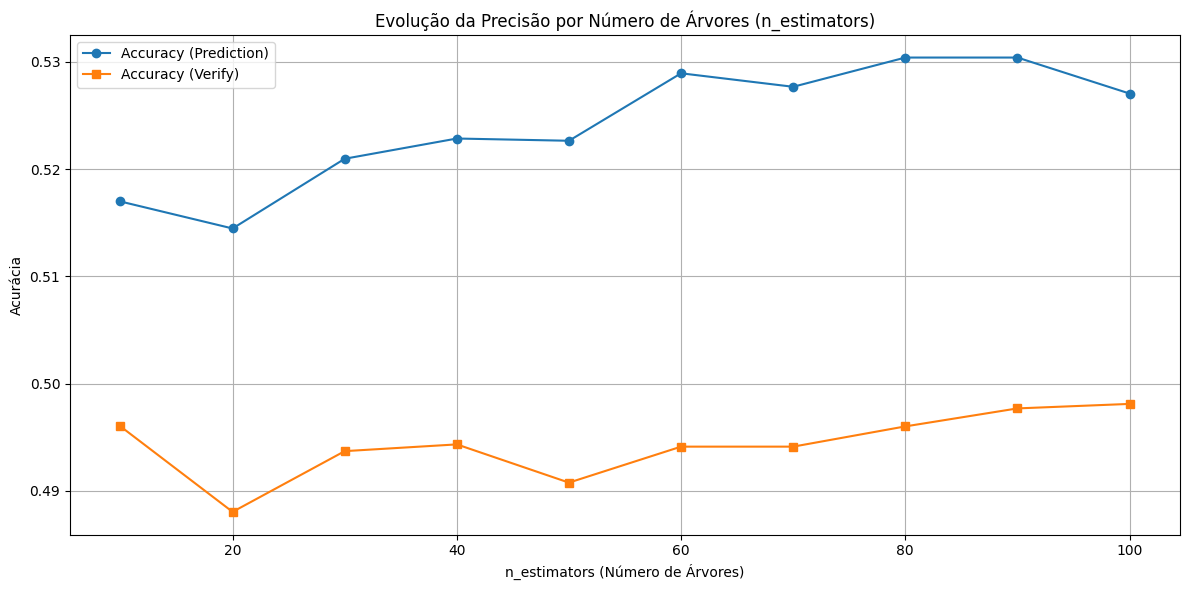


Resumo Geral das Acurácias por n_estimators:
   n_estimators  mean_accuracy_prediction  mean_accuracy_verify
0            10                  0.516981              0.496017
1            20                  0.514465              0.488050
2            30                  0.520964              0.493711
3            40                  0.522851              0.494340
4            50                  0.522642              0.490776
5            60                  0.528931              0.494130
6            70                  0.527673              0.494130
7            80                  0.530398              0.496017
8            90                  0.530398              0.497694
9           100                  0.527044              0.498113


In [73]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import warnings

# Desativa warnings
warnings.filterwarnings("ignore")

# Preparando as colunas de treino
X_Cols = price_data_ABEV[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_ABEV['Prediction']

# Variável adicional de verificação
verify = price_data_ABEV['Verify']

# Intervalo de valores para o hiperparâmetro (n_estimators neste caso)
param_range = range(10, 101, 10)

# Dicionários para armazenar os resultados
results = {"n_estimators": [], "mean_accuracy_prediction": [], "mean_accuracy_verify": []}

# Loop para testar diferentes valores de n_estimators
for n_estimators in param_range:
    print(f"\nTestando para n_estimators={n_estimators}")

    # Criando o modelo Random Forest com o hiperparâmetro atual
    rand_frst_clf_Ambev = RandomForestClassifier(n_estimators=n_estimators, oob_score=True, criterion="gini", random_state=0)

    # Inicializando variáveis para armazenar resultados
    accuracy_scores_ytest = []
    accuracy_scores_verify = []

    # Time Series Split
    tscv = TimeSeriesSplit(n_splits=5)
    fold = 1

    # Loop de cross-validation
    for train_index, test_index in tscv.split(X_Cols):
        # Dividindo os dados em treino e teste para a divisão atual
        X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
        y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
        y_verify = verify.iloc[test_index]

        # Treinando o modelo
        rand_frst_clf_Ambev.fit(X_train, y_train)

        # Fazendo predições
        y_pred = rand_frst_clf_Ambev.predict(X_test)

        # Calculando acurácias
        accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
        accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
        accuracy_scores_ytest.append(accuracy_ytest)
        accuracy_scores_verify.append(accuracy_verify)
        
        # Exibindo acurácias para o fold atual
        print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
        print(f"  Accuracy with Verify: {accuracy_verify:.4f}")


        fold += 1

    # Calculando as médias de acurácia para o hiperparâmetro atual
    mean_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
    mean_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

    # Armazenando os resultados no dicionário
    results["n_estimators"].append(n_estimators)
    results["mean_accuracy_prediction"].append(mean_accuracy_ytest)
    results["mean_accuracy_verify"].append(mean_accuracy_verify)

    # Exibindo os resultados do hiperparâmetro atual
    print(f"  Média de acurácia com Prediction: {mean_accuracy_ytest:.4f}")
    print(f"  Média de acurácia com Verify: {mean_accuracy_verify:.4f}")



# Convertendo os resultados para DataFrame
results_df = pd.DataFrame(results)

# Gerando gráficos para visualizar as métricas
plt.figure(figsize=(12, 6))

# Gráfico das médias de acurácias
plt.plot(results_df["n_estimators"], results_df["mean_accuracy_prediction"], label="Accuracy (Prediction)", marker="o")
plt.plot(results_df["n_estimators"], results_df["mean_accuracy_verify"], label="Accuracy (Verify)", marker="s")

# Configuração do gráfico
plt.title("Evolução da Precisão por Número de Árvores (n_estimators)")
plt.xlabel("n_estimators (Número de Árvores)")
plt.ylabel("Acurácia")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

results_df.head()



#### Max_depth_values - Prediction

In [94]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import warnings

# Desativa warnings
warnings.filterwarnings("ignore")


# Preparando as colunas de treino
X_Cols = price_data_ABEV[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_ABEV['Prediction']

# Variável adicional de verificação
verify = price_data_ABEV['Verify']

# Time Series Split: Número de divisões
tscv = TimeSeriesSplit(n_splits=5)

# Inicializando variáveis para armazenar resultados
report_dict = {}
accuracy_scores_ytest = []
accuracy_scores_verify = []
predictions = []
verify_values = []
actual_y_test_values = []

# Laço para ajustar o max_depth de 1 a 40
for max_depth in range(1, 41):  # max_depth variando de 1 a 40
    print(f"\nAjustando o max_depth = {max_depth}:")
    
    # Criando o modelo Random Forest com o max_depth atual
    rand_frst_clf_Ambev = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", 
                                                 max_depth=max_depth, random_state=0)
    
    fold = 1  # Inicializando o contador do fold

    for train_index, test_index in tscv.split(X_Cols):
        print(f"  Fold {fold}:")
        
        # Dividindo os dados em treino e teste para a divisão atual
        X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
        y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
        y_verify = verify.iloc[test_index]
        
        # Treinando o modelo
        rand_frst_clf_Ambev.fit(X_train, y_train)
        
        # Fazendo predições
        y_pred = rand_frst_clf_Ambev.predict(X_test)
        
        # Armazenando predições e valores reais
        predictions.extend(y_pred)
        verify_values.extend(y_verify.values)
        actual_y_test_values.extend(y_test.values)
        
        # Calculando acurácias
        accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
        accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
        accuracy_scores_ytest.append(accuracy_ytest)
        accuracy_scores_verify.append(accuracy_verify)
        
        # Exibindo acurácias para o fold atual
        print(f"    Accuracy with Y_test (Prediction): {accuracy_ytest:.2f}")
        print(f"    Accuracy with Verify: {accuracy_verify:.2f}")
        
        # Gerando o relatório de classificação
        target_names = ['Down Day', 'Up Day']  # Ajuste se necessário
        report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
        
        # Convertendo o relatório em DataFrame
        report_flat = pd.DataFrame(report).transpose()
        report_flat['accuracy_ytest'] = accuracy_ytest
        report_flat['accuracy_verify'] = accuracy_verify
        
        # Armazenando o relatório no dicionário
        report_dict[f"{max_depth}_fold_{fold}"] = report_flat
        fold += 1

# Concatenando os relatórios de todas as divisões
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Calculando as médias de acurácia para cada valor de max_depth
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

# Exibindo as médias de acurácia para o último max_depth ajustado
print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.2f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.2f}")



Ajustando o max_depth = 1:
  Fold 1:
    Accuracy with Y_test (Prediction): 0.58
    Accuracy with Verify: 0.57
  Fold 2:
    Accuracy with Y_test (Prediction): 0.66
    Accuracy with Verify: 0.64
  Fold 3:
    Accuracy with Y_test (Prediction): 0.55
    Accuracy with Verify: 0.53
  Fold 4:
    Accuracy with Y_test (Prediction): 0.55
    Accuracy with Verify: 0.54
  Fold 5:
    Accuracy with Y_test (Prediction): 0.44
    Accuracy with Verify: 0.44


TypeError: list indices must be integers or slices, not str


Ajustando o max_depth = 1:
  Fold 1:
    Accuracy with Y_test (Prediction): 0.58
    Accuracy with Verify: 0.57
  Fold 2:
    Accuracy with Y_test (Prediction): 0.66
    Accuracy with Verify: 0.64
  Fold 3:
    Accuracy with Y_test (Prediction): 0.55
    Accuracy with Verify: 0.53
  Fold 4:
    Accuracy with Y_test (Prediction): 0.55
    Accuracy with Verify: 0.54
  Fold 5:
    Accuracy with Y_test (Prediction): 0.44
    Accuracy with Verify: 0.44
  Média da acurácia com Y_test (Prediction): 0.56
  Média da acurácia com Verify: 0.54

Ajustando o max_depth = 2:
  Fold 1:
    Accuracy with Y_test (Prediction): 0.61
    Accuracy with Verify: 0.59
  Fold 2:
    Accuracy with Y_test (Prediction): 0.66
    Accuracy with Verify: 0.61
  Fold 3:
    Accuracy with Y_test (Prediction): 0.54
    Accuracy with Verify: 0.49
  Fold 4:
    Accuracy with Y_test (Prediction): 0.58
    Accuracy with Verify: 0.55
  Fold 5:
    Accuracy with Y_test (Prediction): 0.50
    Accuracy with Verify: 0.46
  Média

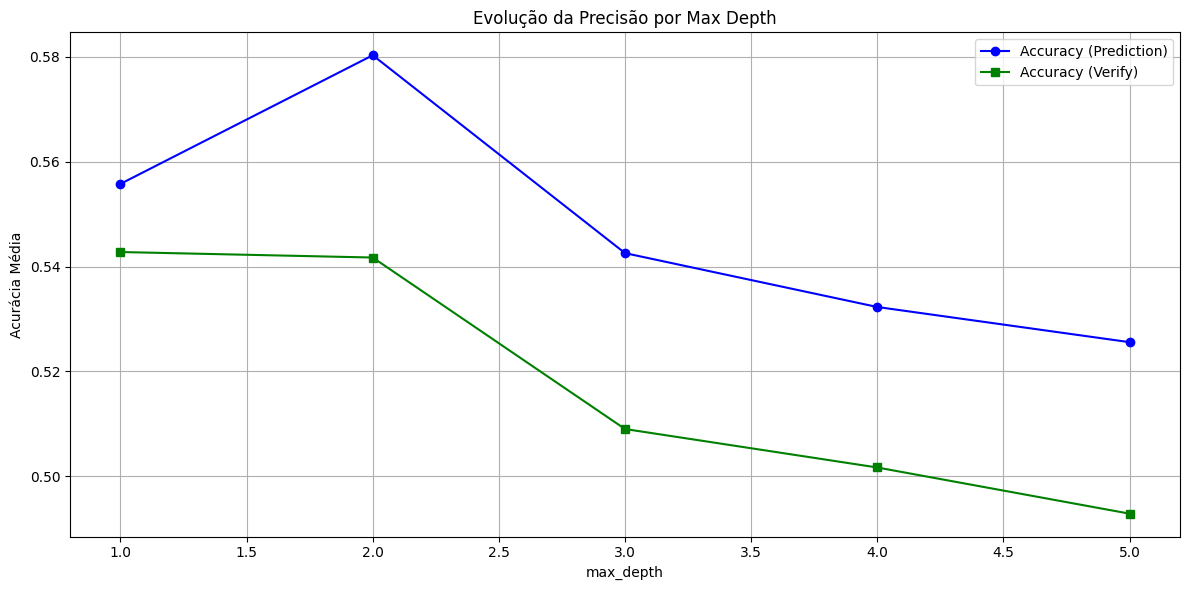

,max_depth,mean_accuracy_prediction,mean_accuracy_verify
0,1,0.555765,0.542767
1,2,0.580294,0.541719
2,3,0.542558,0.509015
3,4,0.532285,0.501677
4,5,0.525577,0.492872


In [99]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt
import warnings

# Desativa warnings
warnings.filterwarnings("ignore")

# Preparando as colunas de treino
X_Cols = price_data_ABEV[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_ABEV['Prediction']

# Variável adicional de verificação
verify = price_data_ABEV['Verify']

# Time Series Split: Número de divisões
tscv = TimeSeriesSplit(n_splits=5)

# Inicializando variáveis para armazenar resultados
accuracy_ytest_by_depth = []
accuracy_verify_by_depth = []
depth_values = []

# Laço para ajustar o max_depth de 1 a 40
for max_depth in range(1, 6):  # max_depth variando de 1 a 40
    print(f"\nAjustando o max_depth = {max_depth}:")
    
    # Criando o modelo Random Forest com o max_depth atual
    rand_frst_clf_Ambev = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", 
                                                 max_depth=max_depth, random_state=0)
    
    fold = 1  # Inicializando o contador do fold
    accuracy_scores_ytest = []
    accuracy_scores_verify = []

    for train_index, test_index in tscv.split(X_Cols):
        print(f"  Fold {fold}:")
        
        # Dividindo os dados em treino e teste para a divisão atual
        X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
        y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
        y_verify = verify.iloc[test_index]
        
        # Treinando o modelo
        rand_frst_clf_Ambev.fit(X_train, y_train)
        
        # Fazendo predições
        y_pred = rand_frst_clf_Ambev.predict(X_test)
        
        # Calculando acurácias
        accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
        accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
        accuracy_scores_ytest.append(accuracy_ytest)
        accuracy_scores_verify.append(accuracy_verify)

        # Exibindo acurácias para o fold atual
        print(f"    Accuracy with Y_test (Prediction): {accuracy_ytest:.2f}")
        print(f"    Accuracy with Verify: {accuracy_verify:.2f}")        

        fold += 1

    # Calculando as médias de acurácia para o max_depth atual
    mean_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
    mean_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

    # Armazenando as médias no gráfico
    depth_values.append(max_depth)
    accuracy_ytest_by_depth.append(mean_accuracy_ytest)
    accuracy_verify_by_depth.append(mean_accuracy_verify)

    # Exibindo os resultados do max_depth atual
    print(f"  Média da acurácia com Y_test (Prediction): {mean_accuracy_ytest:.2f}")
    print(f"  Média da acurácia com Verify: {mean_accuracy_verify:.2f}")

# Gerando gráficos para visualizar as métricas
plt.figure(figsize=(12, 6))

# Plotando as médias de acurácia
plt.plot(depth_values, accuracy_ytest_by_depth, label="Accuracy (Prediction)", marker="o", color="blue")
plt.plot(depth_values, accuracy_verify_by_depth, label="Accuracy (Verify)", marker="s", color="green")

# Configuração do gráfico
plt.title("Evolução da Precisão por Max Depth")
plt.xlabel("max_depth")
plt.ylabel("Acurácia Média")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Exibindo resumo final
results_df = pd.DataFrame({
    "max_depth": depth_values,
    "mean_accuracy_prediction": accuracy_ytest_by_depth,
    "mean_accuracy_verify": accuracy_verify_by_depth
})

results_df.head()



In [93]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd

# Supondo que você já tem o price_data_ABEV carregado
X_Cols = price_data_ABEV[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_ABEV['Prediction']

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Lista para armazenar os resultados
results = []

# Lista de valores para max_depth (10, 20, ..., 1000 e None)
max_depth_values = list(range(10, 51, 10)) + [None]

# Loop para testar diferentes valores de max_depth
for max_depth in max_depth_values:
    # Criar o modelo de Random Forest com o max_depth atual
    rand_frst_clf = RandomForestClassifier(
        n_estimators=100,  # Número fixo de estimadores
        max_depth=max_depth,
        oob_score=True,
        criterion="gini",
        random_state=0
    )
    
    # Ajustar o modelo aos dados de treino
    rand_frst_clf.fit(X_train, y_train)
    
    # Fazer previsões nos dados de teste
    y_pred = rand_frst_clf.predict(X_test)
    
    # Calcular acurácia
    accuracy = accuracy_score(y_test, y_pred) * 100.0
    
    # Armazenar o resultado
    results.append((max_depth, accuracy))
    
    # Imprimir progresso
    max_depth_str = 'None' if max_depth is None else max_depth
    print(f'max_depth: {max_depth_str}, Accuracy: {accuracy:.2f}%')

# Converter resultados para um DataFrame para análise futura
results_df = pd.DataFrame(results, columns=['max_depth', 'Accuracy'])

# Exibir os 5 primeiros resultados
print(results_df.head())


max_depth: 10, Accuracy: 72.26%
max_depth: 20, Accuracy: 75.61%
max_depth: 30, Accuracy: 75.68%
max_depth: 40, Accuracy: 75.89%
max_depth: 50, Accuracy: 75.89%
max_depth: None, Accuracy: 75.89%
   max_depth   Accuracy
0       10.0  72.257163
1       20.0  75.611461
2       30.0  75.681342
3       40.0  75.890985
4       50.0  75.890985


#### Max_samples

In [101]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd

# Supondo que você já tem o price_data_ABEV carregado
X_Cols = price_data_ABEV[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_ABEV['Prediction']

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Lista para armazenar os resultados
results = []

# Lista de valores para max_samples (10, 20, ..., 1000 e None)
max_samples_values = list(range(10, 51, 10)) + [None]

# Loop para testar diferentes valores de max_samples
for max_samples in max_samples_values:
    # Criar o modelo de Random Forest com o max_samples atual
    rand_frst_clf = RandomForestClassifier(
        n_estimators=100,  # Número fixo de estimadores
        max_samples=max_samples,
        oob_score=True,
        criterion="gini",
        random_state=0
    )
    
    # Ajustar o modelo aos dados de treino
    rand_frst_clf.fit(X_train, y_train)
    
    # Fazer previsões nos dados de teste
    y_pred = rand_frst_clf.predict(X_test)
    
    # Calcular acurácia
    accuracy = accuracy_score(y_test, y_pred) * 100.0
    
    # Armazenar o resultado
    results.append((max_samples, accuracy))
    
    # Imprimir progresso
    max_sambples_str = 'None' if max_samples is None else max_samples
    print(f'max_samples: {max_sambples_str}, Accuracy: {accuracy:.2f}%')




max_samples: 10, Accuracy: 61.64%
max_samples: 20, Accuracy: 63.59%
max_samples: 30, Accuracy: 63.73%
max_samples: 40, Accuracy: 62.82%
max_samples: 50, Accuracy: 64.29%
max_samples: None, Accuracy: 75.89%


#### Max_leafs

In [102]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd


# Supondo que você já tem o price_data_ABEV carregado
X_Cols = price_data_ABEV[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_ABEV['Prediction']

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Lista para armazenar os resultados
results = []

# Lista de valores para max_leaf_nodes (10, 20, ..., 1000 e None)
max_leaf_nodes_values = list(range(10, 101, 10)) + [None]

# Loop para testar diferentes valores de max_leaf_nodes
for max_leaf_nodes in max_leaf_nodes_values:
    # Criar o modelo de Random Forest com o max_leaf_nodes atual
    rand_frst_clf = RandomForestClassifier(
        n_estimators=100,  # Número fixo de estimadores
        max_leaf_nodes=max_leaf_nodes,
        oob_score=True,
        criterion="gini",
        random_state=0
    )
    
    # Ajustar o modelo aos dados de treino
    rand_frst_clf.fit(X_train, y_train)
    
    # Fazer previsões nos dados de teste
    y_pred = rand_frst_clf.predict(X_test)
    
    # Calcular a acurácia
    accuracy = accuracy_score(y_test, y_pred) * 100.0
    
    # Armazenar o resultado
    results.append((max_leaf_nodes, accuracy))
    
    # Imprimir progresso
    max_leaf_nodes_str = 'None' if max_leaf_nodes is None else max_leaf_nodes
    print(f'max_leaf_nodes: {max_leaf_nodes_str}, Accuracy: {accuracy:.2f}%')



max_leaf_nodes: 10, Accuracy: 64.78%
max_leaf_nodes: 20, Accuracy: 65.20%
max_leaf_nodes: 30, Accuracy: 67.23%
max_leaf_nodes: 40, Accuracy: 68.13%
max_leaf_nodes: 50, Accuracy: 68.41%
max_leaf_nodes: 60, Accuracy: 69.25%
max_leaf_nodes: 70, Accuracy: 69.74%
max_leaf_nodes: 80, Accuracy: 69.95%
max_leaf_nodes: 90, Accuracy: 70.37%
max_leaf_nodes: 100, Accuracy: 70.79%
max_leaf_nodes: None, Accuracy: 75.89%


### ITAÚ